In [268]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import split, col, explode

In [269]:
pip install mplcursors

Note: you may need to restart the kernel to use updated packages.


In [270]:
import mplcursors

In [271]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.appName("SpotifyAnalysis").master("spark://spark-master:7077").getOrCreate()

### Importing data

In [272]:
data = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)
data_by_artist = spark.read.csv("hdfs://namenode:9000/data_by_artist.csv", header=True, inferSchema=True)
data_by_genres = spark.read.csv("hdfs://namenode:9000/data_by_genres.csv", header=True, inferSchema=True)
data_by_year = spark.read.csv("hdfs://namenode:9000/data_by_year.csv", header=True, inferSchema=True)
data_w_genres = spark.read.csv("hdfs://namenode:9000/data_w_genres.csv", header=True, inferSchema=True)

### Data Preprocessing

In [273]:
dropped_data_columns = ["instrumentalness", "id"]
dropped_data_by_artist_columns = ["instrumentalness", "mode"]
dropped_data_by_genres_columns = ["instrumentalness", "speechiness"]
dropped_data_by_year_columns = ["instrumentalness", "speechiness", "mode"]
dropped_data_w_genres = ["instrumentalness", "speechiness"]

min_data = data.drop(*dropped_data_columns).dropna(how="all")
min_data_by_artist = data_by_artist.drop(*droppped_data_by_artist_columns).dropna(how="all")
min_data_by_genres = data_by_genres.drop(*dropped_data_by_genres_columns).dropna(how="all")
min_data_by_year = data_by_year.drop(*dropped_data_by_year_columns).dropna(how="all")
min_data_w_genres = data_w_genres.drop(*dropped_data_w_genres).dropna(how="all")

### Creating tables and views

In [274]:
min_data.createOrReplaceTempView("data")
min_data_by_artist.createOrReplaceTempView("data_by_artist")
min_data_by_genres.createOrReplaceTempView("data_by_genres")
min_data_by_year.createOrReplaceTempView("data_by_year")
min_data_w_genres.createOrReplaceTempView("data_w_genres")

## Complex Queries

#### Average popularity by artist

In [275]:
spark.sql("""
    SELECT 
        a.artists,
        AVG(a.popularity) AS avg_popularity
    FROM 
        data_by_artist a
    JOIN 
        data_by_genres g ON a.key = g.key
    GROUP BY 
        a.artists
    HAVING 
        AVG(a.popularity) > 60  -- Example threshold
    ORDER BY 
        avg_popularity DESC
""").show()
#Average popularity by artist: calculates average popularity for each artist 
#across different genres 

+----------------+--------------+
|         artists|avg_popularity|
+----------------+--------------+
|     Ritt Momney|          93.0|
|       Lele Pons|          92.0|
| Los Legendarios|          90.0|
|        Jerry Di|          89.0|
|       Surf Mesa|          88.0|
|          Emilee|          88.0|
|     salem ilese|          88.0|
|             A7S|          87.0|
|  Nomcebo Zikode|          86.0|
|Sammy & Falsetto|          86.0|
|          Osquel|          86.0|
|         Beltito|          86.0|
|    Lenny Santos|          86.0|
|       Master KG|          86.0|
|            Towy|          86.0|
|        Octavian|          85.0|
|          Angèle|          85.0|
|            HVME|          85.0|
|       Jawsh 685|          85.0|
|      THE SCOTTS|          85.0|
+----------------+--------------+
only showing top 20 rows



#### Genre influence on popularity

In [276]:
spark.sql("""
    SELECT 
        g.genres,
        y.year,
        AVG(g.popularity) AS avg_popularity
    FROM 
        data_by_genres g
    JOIN 
        data_by_year y ON g.key = y.key
    GROUP BY 
        g.genres, y.year
    ORDER BY 
        y.year ASC, avg_popularity DESC
""").show()
#How genre influences average popularity overtime

+--------------------+----+------------------+
|              genres|year|    avg_popularity|
+--------------------+----+------------------+
|            basshall|1921| 80.66666666666666|
|       ritmo kombina|1921| 76.33333333333333|
|             dong-yo|1921|              70.0|
|german undergroun...|1921|              67.0|
|                alte|1921|              66.0|
|  musica afroperuana|1921|              65.0|
|        gujarati pop|1921|              64.0|
|      australian r&b|1921|             62.25|
|         rebel blues|1921| 61.54933333333334|
|         indian folk|1921|              60.5|
|            pop soul|1921| 60.30357142857143|
|    electronic djent|1921|             60.25|
|           lo-fi vgm|1921|              60.0|
|         marathi pop|1921|              59.0|
| nashville americana|1921|             58.25|
|      gaming dubstep|1921|              58.0|
|          bath indie|1921|              58.0|
|        chinese jazz|1921|              58.0|
|      rap co

#### Instumentalness vs. Popularity across artists

In [277]:
# This will replace the brackets and split the string into an array
data = data.withColumn("artists", split(col("artists"), ",\s*"))  # Split on comma

# Now explode the artists column
exploded_data = data.select(explode(data.artists).alias("artist"), "*")
exploded_data.createOrReplaceTempView("exploded_data")

# Now use the exploded DataFrame for the join
query_3 = spark.sql("""
    SELECT 
        ed.artist AS artist, 
        AVG(ed.instrumentalness) AS avg_instrumentalness, 
        AVG(ed.popularity) AS avg_popularity, 
        COUNT(ed.name) AS num_songs
    FROM 
        exploded_data ed
    JOIN 
        data_by_artist da
    ON 
        ed.artist = da.artists
    WHERE 
        ed.popularity > 0  -- No filtering for popularity to see results
    GROUP BY 
        ed.artist
    ORDER BY 
        avg_popularity DESC
""").show()


+-------------------+--------------------+--------------+---------+
|             artist|avg_instrumentalness|avg_popularity|num_songs|
+-------------------+--------------------+--------------+---------+
|               Coda|                 0.0|          61.0|        1|
|       Liz Callaway|             1.46E-6|          41.0|        1|
|      Andrae Crouch|                 0.0|          31.0|        1|
|       Commissioned|                 0.0|          31.0|        1|
|       Patti Austin|                 0.0|          31.0|        1|
|        Daryl Coley|                 0.0|          31.0|        1|
|POLYPHON WITH BELLS|             0.00107|          24.0|        1|
|        Zero Mostel|                 0.0|          16.0|        1|
|        Johnny Cash|                 0.0|           8.0|        1|
|           Dave Koz|                 0.0|           4.0|        1|
|     Brownie McGhee|        0.0118548175|          2.75|        4|
+-------------------+--------------------+------

#### Correlations between Loudness and energy in popular songs

In [278]:
query_4 = spark.sql("""
    SELECT 
        regexp_replace(d.artists, '\\\\[|\\\\]|\\'','') AS artist,  -- Escape brackets and quotes
        d.name AS song_name, 
        d.loudness AS song_loudness, 
        da.energy AS song_energy, 
        d.popularity AS song_popularity
    FROM 
        data d
    JOIN 
        data_by_artist da
    ON 
        regexp_replace(d.artists, '\\\\[|\\\\]|\\'','') = da.artists  -- Match cleaned artist strings
    WHERE 
        d.popularity > 60  -- Focusing on popular songs
    ORDER BY 
        d.loudness DESC, da.energy DESC
""").show()
#Correlations between loudness and energy in popular songs

+--------------------+--------------------+-------------+-------------------+---------------+
|              artist|           song_name|song_loudness|        song_energy|song_popularity|
+--------------------+--------------------+-------------+-------------------+---------------+
|Fear, and Loathin...|         Let Me Hear|        1.023|             0.9875|             64|
|          Lil Darkie|            GENOCIDE|        0.457| 0.8956666666666666|             70|
|          The Police|Every Little Thin...|       -9.997| 0.6871311475409836|             73|
|    Sleeping At Last|        Already Gone|       -9.997|            0.24385|             75|
|      Blonde Redhead|For the Damaged Coda|       -9.995|0.33399999999999996|             61|
|              T. Rex|Bang a Gong (Get ...|       -9.992|            0.64025|             63|
|               Wings|    Live And Let Die|       -9.988| 0.4909221311475409|             64|
|        Night Lovell|          Dark Light|       -9.985| 0.

## Simple Queries

#### Top Genres by Danceability and Energy

+--------------------+------------------+------------------+
|              genres|  avg_danceability|        avg_energy|
+--------------------+------------------+------------------+
|  experimental house|             0.929|             0.573|
|          guam indie|              0.92|             0.319|
|       dutch hip hop|0.9109999999999999|             0.635|
|       dutch rap pop|            0.9074|0.7092666666666666|
|british children'...|             0.906|             0.596|
|    indie deutschrap|             0.903|             0.253|
|     trance mexicano|             0.902|0.8370000000000001|
|            footwork|             0.897|             0.568|
|       funk paulista|0.8959999999999999|             0.675|
|           proto-rap|             0.893|             0.515|
+--------------------+------------------+------------------+



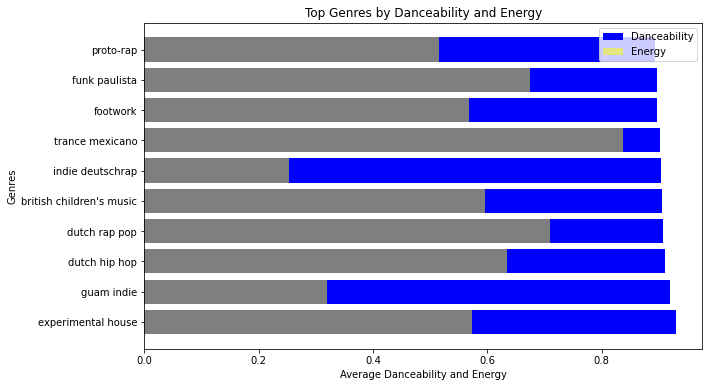

In [279]:
query1 = spark.sql("""
    SELECT genres, AVG(danceability) AS avg_danceability, AVG(energy) AS avg_energy
    FROM data_by_genres
    GROUP BY genres
    ORDER BY avg_danceability DESC, avg_energy DESC
    LIMIT 10
""")
query1.show()

df1 = query1.toPandas()

#Plotting
plt.figure(figsize=(10, 6))
plt.barh(df1["genres"], df1["avg_danceability"], color="blue", label="Danceability")
plt.barh(df1["genres"], df1["avg_energy"], color="yellow", alpha=0.5, label="Energy")
plt.xlabel("Average Danceability and Energy")
plt.ylabel("Genres")
plt.title("Top Genres by Danceability and Energy")
plt.legend()
mplcursors.cursor(hover=True)
plt.show()

#### Longest Songs by Genres

+--------------------+------------------+
|              genres| avg_duration_mins|
+--------------------+------------------+
|bulgarian experim...| 39.70977777777777|
|histoire pour enf...|27.033333333333335|
|musique pour enfants|27.033333333333335|
|             oratory|          24.48805|
|          microtonal|20.144441666666665|
|               432hz| 17.48145555555555|
|      hungarian folk|12.224261111111108|
|  magyar alternative|12.224261111111108|
|progressive power...|11.939116666666667|
|  canadian post-rock| 11.15123888888889|
+--------------------+------------------+



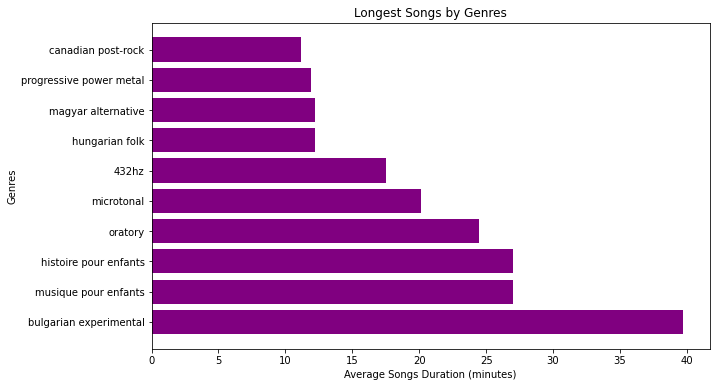

In [280]:
query2 = spark.sql("""
    SELECT genres, AVG(duration_ms)/60000 AS avg_duration_mins
    FROM data_by_genres
    GROUP BY genres
    ORDER BY avg_duration_mins DESC
    LIMIT 10
""")
query2.show()

query2_df = query2.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(query2_df["genres"], query2_df["avg_duration_mins"], color="purple")
plt.xlabel("Average Songs Duration (minutes)")
plt.ylabel("Genres")
plt.title("Longest Songs by Genres")
#plt.gca().invert_yaxis()
mplcursors.cursor(hover=True)
plt.show()
#longest songs by genre

#### Top10 Most Danceable Songs

+----+--------------------+----------------+----------+
|year|             artists|max_danceability|song_count|
+----+--------------------+----------------+----------+
|1989|        ['Tone-Loc']|           0.988|         3|
|2012|['Pitbull', 'Trin...|           0.986|         1|
|2007|['Young Boss', 'T...|           0.986|         1|
|2018|      ['ITSOKTOCRY']|           0.985|         1|
|2015|      ['Astra Teck']|           0.983|         2|
|1997|       ['Daft Punk']|            0.98|        12|
|2020|        ['347aidan']|            0.98|         1|
|1984|['The Jacksons', ...|            0.98|         1|
|1990|     ['Vanilla Ice']|            0.98|         3|
|2017|    ['XXXTENTACION']|           0.979|        18|
+----+--------------------+----------------+----------+



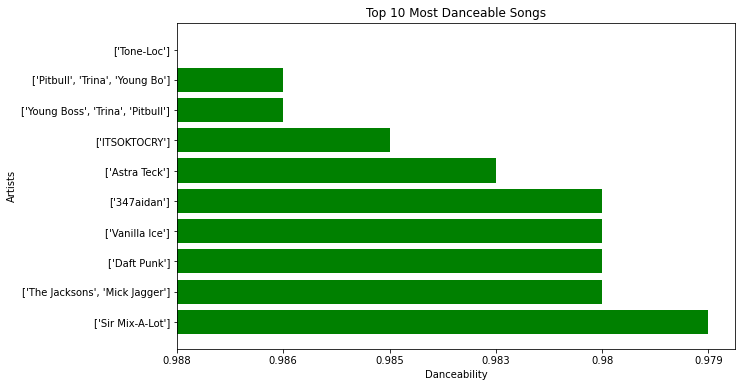

In [281]:
query3 = spark.sql("""
    SELECT year, artists, MAX(danceability) AS max_danceability, COUNT(name) as song_count
    FROM data 
    GROUP BY year, artists
    ORDER BY max_danceability DESC
    LIMIT 10
""")
query3.show()

query3_df = query3.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(query3_df["artists"], query3_df["max_danceability"], color="green")
plt.xlabel("Danceability")
plt.ylabel("Artists")
plt.title("Top 10 Most Danceable Songs")
plt.gca().invert_yaxis()
mplcursors.cursor(hover=True)
plt.show()

#Top10 most danceable songs by year